<hr>
<h1>Regressão Linear Multipla</h1>

Neste Notebook, continuamos a investigação iniciada em MLR_v0.
Relembrando:

Estou explorando um exemplo de aplicação de Regressão Linear Multipla (RLM) como modelo preditor, utilizando os dados de Preço de Casas, do Kaggle.

<h3>Passos Anteriores:</h3>

    - Aplicamos o MLR aos dados:
            - Sem dados faltantes;
            - Sem dados faltantes e sem outliers;

   
<h3> Próximos passos</h3>

    - Verificar a colineariedade entre as variáveis.
    
    
<hr>
  Começo importando todas as bibliotecas usadas ao longo do programa;
  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

<hr>Vou reutilizar algumas funções definidas anteriormente, com algumas modificações 

In [2]:
def beam_me_up_Scotty(file):
    dataset = pd.read_csv(file)    
    print(dataset.shape)
    return dataset

In [3]:
def MLR_model(state):
    #y = dataset['SalePrice']
    #x_num = [ cname for cname in dataset.columns if dataset[cname].dtype in ['int64','float64']]
    #X=dataset[x_num].drop(['SalePrice'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=state)
    print('Numericos: ',X.shape[1])
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
    coeff_df
    y_pred = regressor.predict(X_test)
    df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Model Score: ',regressor.score(X_test,y_test))
#    Revelio(df)
    sns.regplot(x='Actual', y='Predicted',data=df)
    return df

<hr>

Novamente, vamos carregar os dados, extrair apenas os dados numéricos e armazenar as variáveis independentes de interesse em X, e a variável dependente (SalePrice) em y;

<h1> Adicionalmente</h1>Excluo da análise variáveis que tenham menos que 8 valores únicos (uma variável que aceite apenas valores 0 e 1, por exemplo, ficará de fora da análise)

In [4]:
dataset=beam_me_up_Scotty('data/train_NoNAN_NoOutlier.csv')[3:]
dataset.drop(['Unnamed: 0', 'Id','Unnamed: 0.1'], axis = 1, inplace=True) # Removo itens não relevantes;
x_num = [ cname for cname in dataset.columns if dataset[cname].dtype in ['int64','float64'] and dataset[cname].nunique() > 8]
X=dataset[x_num].drop(['SalePrice'], axis=1)
y = dataset['SalePrice']

(552, 79)


<hr>
<h1> Uma ...</h1> forma visual e usual de olharmos para a colineariedade, é atravéz de uma matriz de correlação das variáveis em X. Vejamos: 

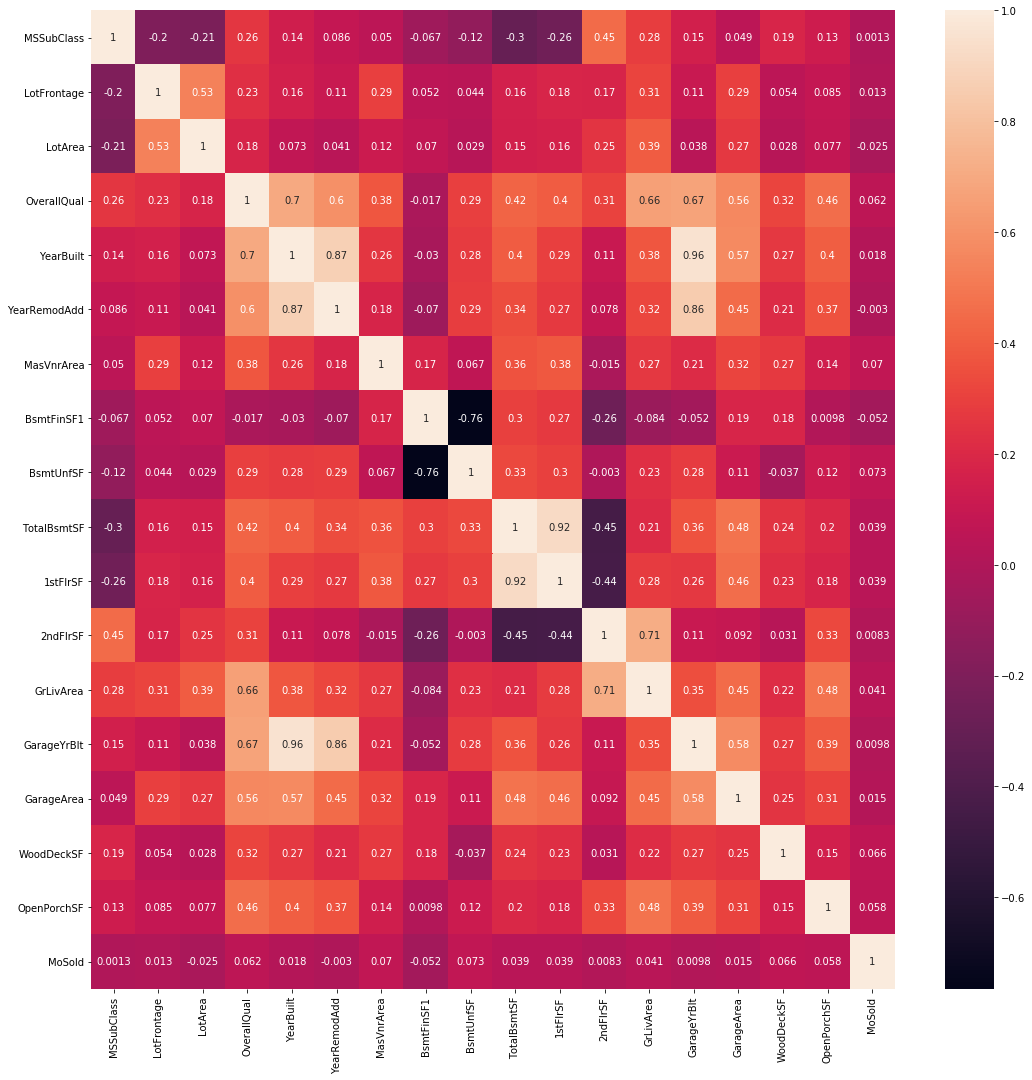

In [5]:
corr_df = X.corr(method='spearman')#[3:]
plt.figure(figsize=(18, 18))
sns.heatmap(corr_df, annot=True)

<hr>
<h1> Observemos que </h1>

- Na maior parte dos casos, as correlações são pequenas |r|<0.5;

- Há 10 casos com correlação |r|>= 0.6 ;

- Há 4 casos com correlação |r|>0.8. Nesses casos, há muitas vezes uma relação causal óbvia, como, por exemplo, a área da garagem (GarageArea) e o número de carros que a garagem acomoda (GarageCars). Ou o ano de construção e o ano de construção da garagem.
                

<hr>
Como lidar com esses casos?

   - Poderíamos, por exemplo, escolher um único membro de cada grupo de variáveis correlacionadas para permanecer na análise.
   Essa variável seria a "representante" daquele conjunto na análise. Poderiamos escolher, convenientemente, aquela que melhor
   se correlaciona com o preço de venda (variável dependente).
   
   - Quando a base de dados é muito grande e/ou são muitos os conjuntos de variáveis correlacionadas, uma abordagem  interessante seria a Análise de Componentes Principais (PCA, do inglês). Esta análise encontra funções, ortogonais entre si, que tentam representar, da melhor forma possível, os padrões de covariância no conjunto de dados. Pela ortogonalidade, o uso das componentes da PCA como proxy dos dados elimina o problema de interdependência do conjunto de dados, ao mesmo tempo que reduz significativamente a dimensionalidade da base de dados. Essa análise é muito poderosa, mas nem sempre sua aplicação é trivial ou mesmo útil. Em casos de dados não (ou pouco) correlacionados, por exemplo, a PCA perde seu charme, pois cada componente explicará uma quantidade muito pequena das informações originais.

Na matriz de correlação acima, há poucos casos de correlação significativa. A princípio não estou otimista com o uso da PCA neste caso, mas vamos é claro tentar utilizá-la! 

Vamos aplicar a PCA em todo o conjunto de variáveis independentes (numéricas) e ver o resultado.



In [6]:

x = X.values # converto para uma matriz numérica;

x = StandardScaler().fit_transform(x)
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2','pc3'])

df_pca = pd.concat([principalDf, X], axis = 1)

<hr>Feito!

Vejamos a variância da base de dados que é explicada por cada componente:

In [7]:
pca.explained_variance_ratio_
#df_pca

array([0.29679563, 0.13515435, 0.11082091])

<hr> Não explica muito! Aproximadamente, temos:

- pc1=29% da variância
- pc2=13% da variância
- pc3=11% da variância

Vejamos agora como ficam os scatterplot da primeira componente (pc1) vs variáveis usadas na análise:

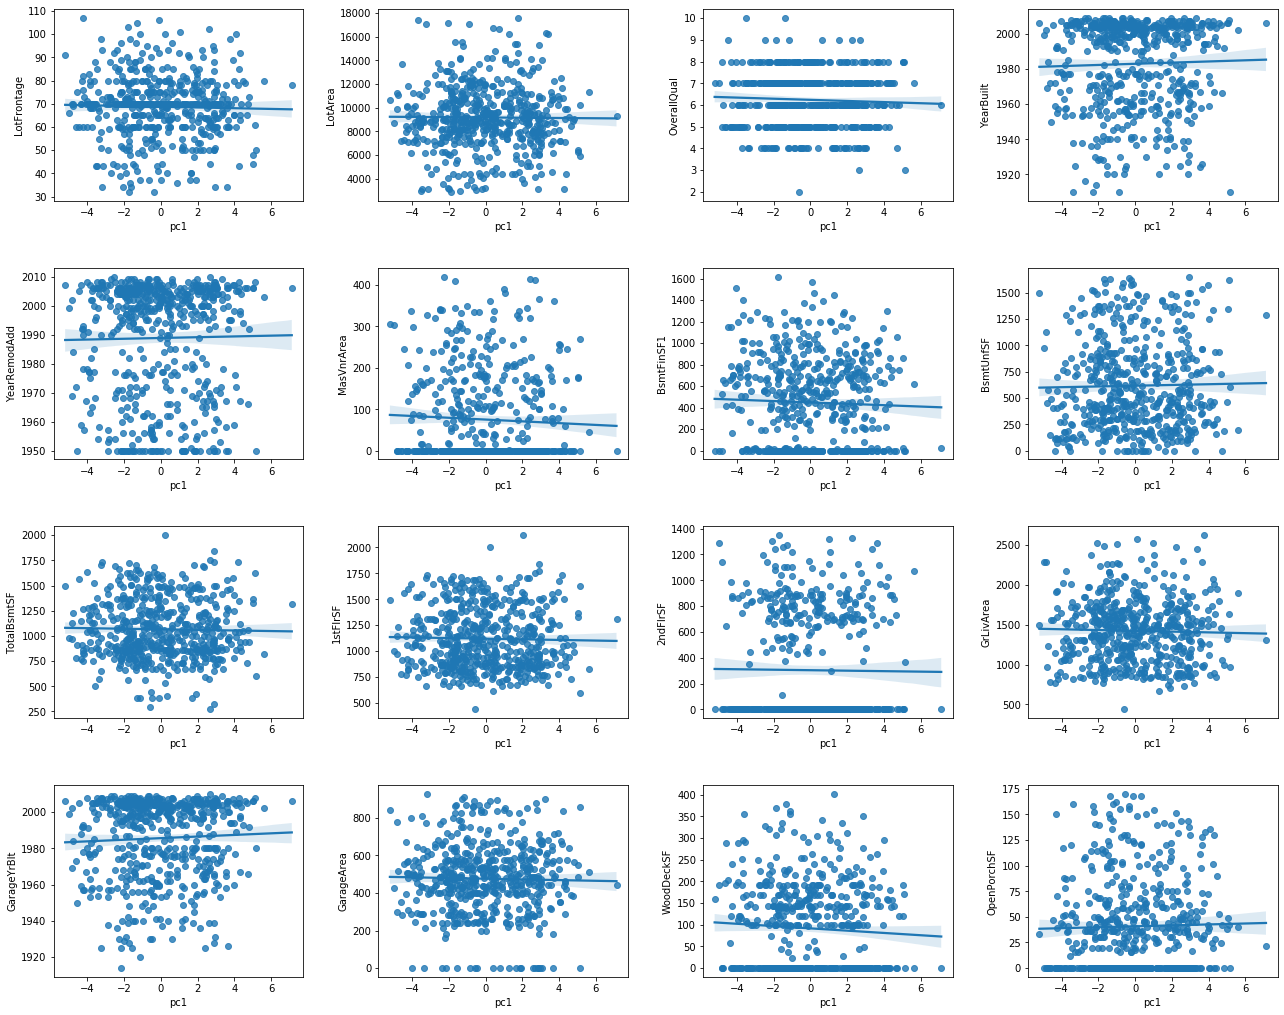

In [8]:
features2 = X.columns #["wheel base", "wheel base", "length", "width", "height", "weight", "engine size", "bore", "stroke",
             #"compression ratio", "horsepower", "peak rpm", "city mpg", "highway mpg", "price"]
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))
for col, ax in zip(features2[1:], axs.ravel()):
    ax = sns.regplot(x='pc1', y=col, data=df_pca,  ax=ax)
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,
                    wspace=0.3)

<hr> 
Neste caso, percebe-se que a aplicação da PCA não é trivial, e torna-se precário utilizar a PCA como proxy dos dados originais.


Vamos ver, por curiosidade, como nosso modelo de regressão linear se sai ao utilizarmos as componentes da PCA para predizer o preço de venda.


(546, 4)
Numericos:  3
Mean Absolute Error: 41536.61028932391
Mean Squared Error: 2941531810.4374375
Root Mean Squared Error: 54235.890427257094
Model Score:  -0.004768806654165791


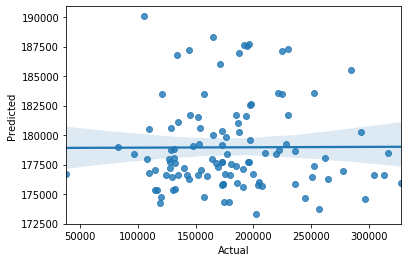

In [9]:
dataset = pd.concat([principalDf, y], axis = 1)
dataset.dropna(inplace=True)
y = dataset['SalePrice']
X=dataset.drop(['SalePrice'], axis=1)
print(dataset.shape)
df=MLR_model(0)

<hr>
<h1>OMG!</h1>

Pois é. Dessa forma ficou muito ruim! Mas nem sempre é assim! Muitas vezes a PCA é uma boa estratégia para reduzir a dimensão da matriz de dados (reduzindo o tempo de modelagem, por exemplo) e remover dados colineares (reduz o viés do modelo).
Contudo, nesse caso, como fora aplicada, os resultados não foram positivos!!
<hr>

Façamos o seguinte:

    - Como neste caso temos poucos conjuntos de dados fortemente correlacionados, vamos analizá-los individualmente.
    
    Vou recarregar os dados originais e vou selecionar os conjuntos de dados, conjunto por conjunto, que são correlacionados entre si (veja a matriz de correlação acima) ...
  
    


In [10]:

dataset=beam_me_up_Scotty('data/train_NoNAN_NoOutlier.csv')[3:]
dataset.drop(['Unnamed: 0', 'Id','Unnamed: 0.1'], axis = 1, inplace=True) # Removo itens não relevantes;
X=dataset[x_num].drop(['SalePrice'], axis=1)


(552, 79)


<hr>

Na matriz de correlação, identifiquei o seguinte conjunto de dados correlacionados:

'YearBuilt', 'YearRemodAdd', 'GrLivArea','GarageYrBlt', 'OverallQual'

Vamos olhar para a matriz de correlação apenas desses dados, e adicionalmente a correlação de cada um com a variável dependente (SalePrice). Para eliminar a colineariedade dos dados, vamos manter apenas aquele com a maior correlação com o SalePrice, e removeremos os demais.

YearBuilt  vs SalePrice r= 0.6778599156875884
YearRemodAdd  vs SalePrice r= 0.6042247620824294
GrLivArea  vs SalePrice r= 0.7582912224284404
GarageYrBlt  vs SalePrice r= 0.6251935316783395
OverallQual  vs SalePrice r= 0.8348945771088325


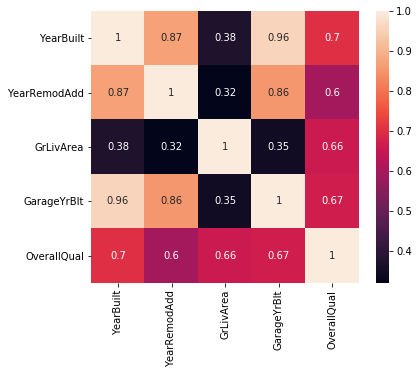

In [11]:
def unidunite(Grupo):
    dfin=X[Grupo]
    corr_df = dfin.corr(method='spearman')#[3:]
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr_df, annot=True)

    r_pc1=[ [Grupo[i],pearsonr(dfin[Grupo[i]],dataset['SalePrice'])[0]] for i in range(0,len(Grupo)) ]
    for i in range(0,len(Grupo)):
        print(r_pc1[i][0],' vs SalePrice r=',r_pc1[i][1])
        
unidunite(['YearBuilt', 'YearRemodAdd', 'GrLivArea','GarageYrBlt', 'OverallQual']) #,'2ndFlrSF', 'TotRmsAbvGrd', 'GarageArea'])
X.drop(['YearBuilt', 'YearRemodAdd', 'GrLivArea','GarageYrBlt'], axis=1,inplace=True)

    

A variável OverallQual apresenta a maior correlação com SalePrice. Logo, mantenho OverallQual e removemo as demais!
<hr>

Agora olhemos para o par ['BsmtFinSF1','BsmtUnfSF']:

BsmtFinSF1  vs SalePrice r= 0.2151682148753297
BsmtUnfSF  vs SalePrice r= 0.18338760648401897


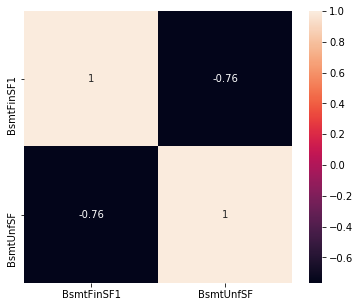

In [12]:
unidunite(['BsmtFinSF1','BsmtUnfSF'])   
X.drop(['BsmtUnfSF'], axis=1,inplace=True)

Escolhemos BsmtFinSF1
<hr>

Por fim, o par '1stFlrSF', 'TotalBsmtSF'

1stFlrSF  vs SalePrice r= 0.5089893346014629
TotalBsmtSF  vs SalePrice r= 0.5552795322821127


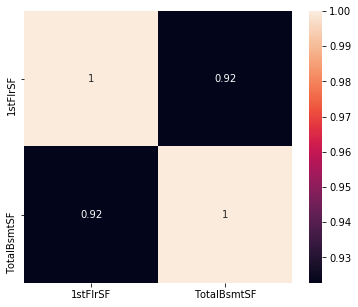

In [13]:
unidunite(['1stFlrSF', 'TotalBsmtSF'])   
X.drop(['1stFlrSF'], axis=1,inplace=True)

In [14]:
#unidunite(['2ndFlrSF', 'TotRmsAbvGrd'])   
#X.drop(['2ndFlrSF'], axis=1,inplace=True)


Mantemos TotalBsmtSF!
<hr>

Contemplamos até aqui os casos de maior correlação a serem analisados. Vamos refazer a matriz de correlação para compararmos com aquela feita lá no inicio!

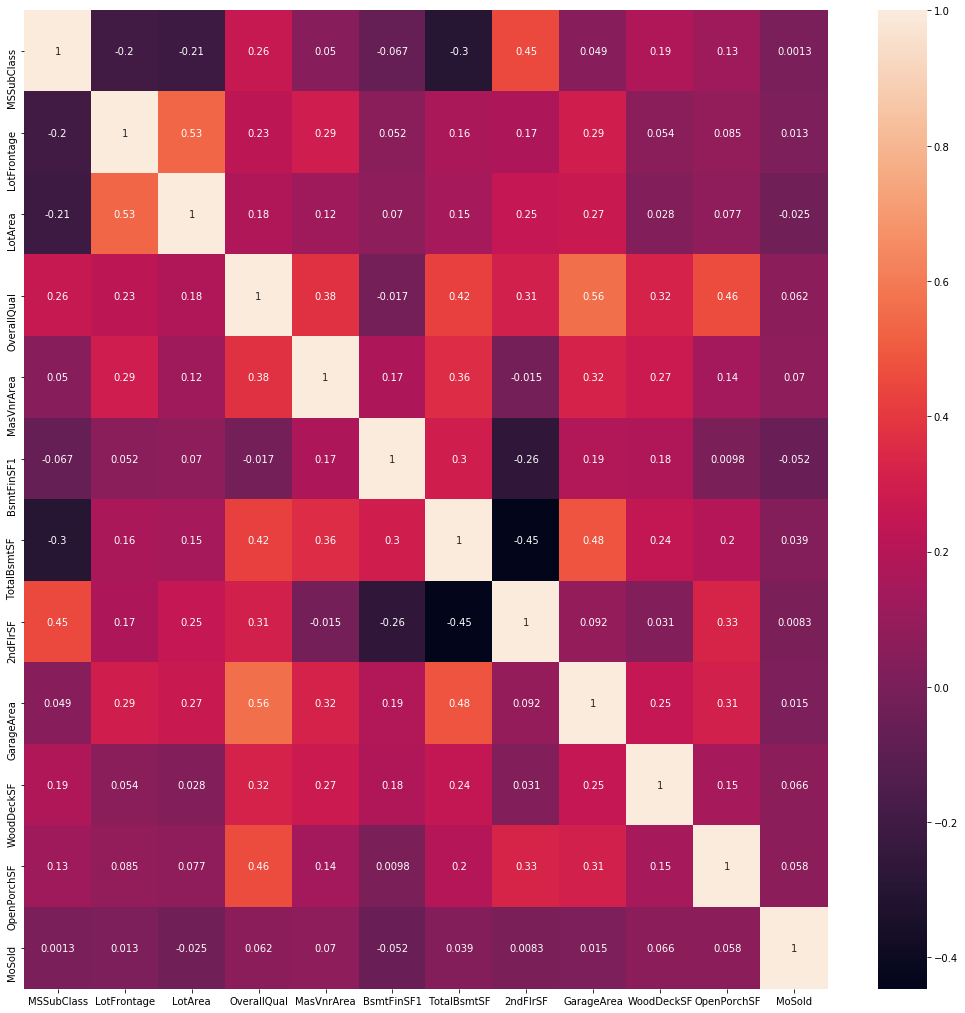

In [15]:
corr_df = X.corr(method='spearman')#[3:]
plt.figure(figsize=(18, 18))
sns.heatmap(corr_df, annot=True)

<hr><h1> Certo ... </h1>

Sobraram apenas correlaçoes nulas, fracas ou medianas. Vamos testar esse grupo de dados em nosso modelo linear!

Numericos:  12
Mean Absolute Error: 14213.377452245659
Mean Squared Error: 355536641.050317
Root Mean Squared Error: 18855.679278411506
Model Score:  0.8785557493267996


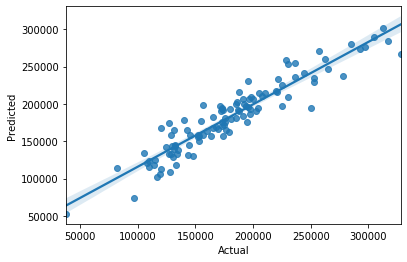

In [16]:
dataset  = pd.concat([X, y], axis = 1)
dataset.dropna(inplace=True)
y = dataset['SalePrice']
X = dataset.drop(['SalePrice'], axis=1)
df=MLR_model(0)

<hr>
<h1> Nada mal! </h1>
Temos agora um conjunto de dados com colineariedade reduzida! Reduziu-se também o número de parâmetros em nossa regressão! Tinhamos 37 variáveis independentes em nossa melhor regressão. Agora, temos 12.

Desses 12 parâmetros, vamos verificar a correlação de cada um com o 'SalePrice'.

In [17]:
Grupo = [ cname for cname in X.columns if X[cname].dtype in ['int64','float64']]
r_pc1=[ [Grupo[i],pearsonr(X[Grupo[i]],dataset['SalePrice'])[0]] for i in range(0,len(Grupo)) ]
correlation = pd.DataFrame(data = r_pc1
             , columns = ['Feature','Correl'])
correlation.sort_values(by='Correl', ascending=False)   
list=[ par[0]  for par in np.array(correlation.sort_values(by='Correl', ascending=False)) ]
correlation.sort_values(by='Correl', ascending=False)

,Feature,Correl
3,OverallQual,0.834948
8,GarageArea,0.696324
6,TotalBsmtSF,0.557594
10,OpenPorchSF,0.414354
4,MasVnrArea,0.408288
7,2ndFlrSF,0.362661
9,WoodDeckSF,0.327837
1,LotFrontage,0.306590
2,LotArea,0.280949
5,BsmtFinSF1,0.212706


<hr>Vou remover, adicionalmente, 'MoSold', uma vez que possui correlação próxima de 0 com o 'SalePrice'.


In [18]:
X.drop(['MoSold'], axis=1,inplace=True)
correlation.drop([11], inplace=True)
correlation.sort_values(by='Correl', ascending=False) 


,Feature,Correl
3,OverallQual,0.834948
8,GarageArea,0.696324
6,TotalBsmtSF,0.557594
10,OpenPorchSF,0.414354
4,MasVnrArea,0.408288
7,2ndFlrSF,0.362661
9,WoodDeckSF,0.327837
1,LotFrontage,0.306590
2,LotArea,0.280949
5,BsmtFinSF1,0.212706


<hr>
<h1>Pois bem ...</h1>

Após uma série de decisões e análises, que resultaram numa redução da base de dados original, restaram apenas 11 variáveis independentes.


Vamos ver como nosso modelo se sai dessa vez:

Numericos:  11
Mean Absolute Error: 14167.22186140338
Mean Squared Error: 354023620.8192237
Root Mean Squared Error: 18815.515427944665
Model Score:  0.8790725669680859


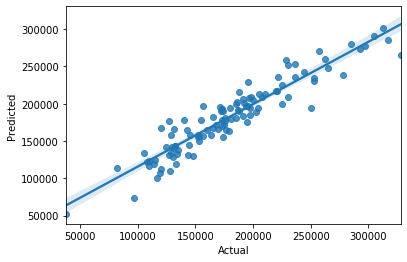

In [19]:
dataset  = pd.concat([X, y], axis = 1)
df=MLR_model(0)


<hr>Pouca diferença, mas houve uma minuscula melhora no score.

Podemos ainda verificar duas coisas, antes de partir:

        - Qual a relação do Score Vs número de variáveis independentes?
        - Qual a variação do Score com relação à amostra escolhida para o treino e teste?
        
Vamos verificar!

Vou modificar o MLR_model para que retorne apenas o score!
Vejamos:


In [22]:
def MLR_model2(state,i):
    y = dataset['SalePrice']
    X_reduced=X[list[0:i]]
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=state)
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    coeff_df = pd.DataFrame(regressor.coef_, X_reduced.columns, columns=['Coefficient'])
    y_pred = regressor.predict(X_test)
    return regressor.score(X_test,y_test)

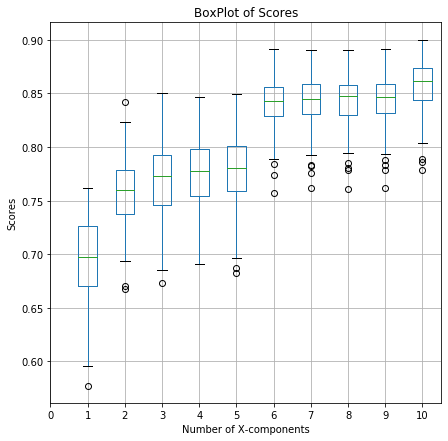

In [23]:
scorem=np.zeros([len(correlation),50])

for i in range(1,len(correlation)):
    scorem[i,:]=[MLR_model2(stat,i) for stat in range(0,50) ]
colunas=[var for var in 'abcdefghij']
Scores = pd.DataFrame(data = np.transpose(scorem[1:,:]), columns = colunas)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
ax= Scores.boxplot(column=colunas)  
ax.set_xticks(range(11)) # <--- set the ticks first
plt.xlabel('Number of X-components')
plt.ylabel('Scores')
plt.title('BoxPlot of Scores')

null=ax.set_xticklabels(['0','1','2','3','4','5','6','7','8','9','10','11'])


<h1> "Fascinating ..." </h1>

Vemos que, com apenas de 6 variáveis independentes, conseguimos alcançar Scores razoáveis. Notem que adicionei as variáveis independentes de acordo com a correlação que apresentam com o SalePrice. Dessa forma, as variáveis com melhor correlação entram primeiro na análise!

Após a sexta componente, os incrementos no score são menores.


<hr>
<h1>Vamos ... </h1> comparar esses resultados com uma aplicação grosseira do MLR. Quero dizer. Vou aplicar o MLR_model em todos os dados numéricos, como feito em MLR_v0 ...

In [24]:
dataset=beam_me_up_Scotty('data/train_NoNAN_NoOutlier.csv')[3:]
dataset.drop(['Unnamed: 0', 'Id','Unnamed: 0.1'], axis = 1, inplace=True) # Removo itens não relevantes;
x_num = [ cname for cname in dataset.columns if dataset[cname].dtype in ['int64','float64'] and dataset[cname].nunique() > 1]

X=dataset[x_num].drop(['SalePrice'], axis=1)
#X = X[~(X == 0).any(axis=1)]
y = dataset['SalePrice']
print(X.shape)

(552, 79)
(549, 27)


In [27]:
Grupo = [ cname for cname in X.columns if X[cname].dtype in ['int64','float64']]
r_pc1=[ [Grupo[i],pearsonr(X[Grupo[i]],dataset['SalePrice'])[0]] for i in range(0,len(Grupo)) ]
correlation = pd.DataFrame(data = r_pc1
             , columns = ['Feature','Correl'])
correlation.sort_values(by='Correl', ascending=False)  


,Feature,Correl
3,OverallQual,0.834895
13,GrLivArea,0.758291
21,GarageCars,0.713739
22,GarageArea,0.698037
5,YearBuilt,0.677860
15,FullBath,0.670159
20,GarageYrBlt,0.625194
6,YearRemodAdd,0.604225
18,TotRmsAbvGrd,0.576503
10,TotalBsmtSF,0.555280


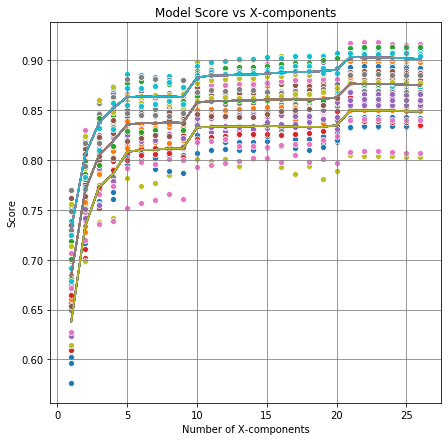

In [28]:
scorem=np.zeros(len(correlation))
scorestd=np.zeros(len(correlation))

for i in range(1,len(correlation)):
    a=[MLR_model2(stat,i) for stat in range(0,50) ]
    scorem[i]=np.average(a)
    scorestd[i]=np.std(a)


    
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
for stat  in  range(0,50):
    score=[  MLR_model2(stat,i) for i in range(1,len(correlation)) ]
    ax1=sns.scatterplot(y=score, x=range(1,len(correlation)), ax=ax1)
    ax1=sns.lineplot(y=scorem[1:],x=range(1,len(correlation)), ax=ax1)
    ax1=sns.lineplot(y=scorem[1:]-scorestd[1:],x=range(1,len(correlation)), ax=ax1)
    ax1=sns.lineplot(y=scorem[1:]+scorestd[1:],x=range(1,len(correlation)), ax=ax1)
    
    plt.title('Model Score vs X-components')
    plt.xlabel('Number of X-components')
    plt.ylabel('Score')
    ax1.grid(b=True, which='major', color='gray', linewidth=0.8)
    

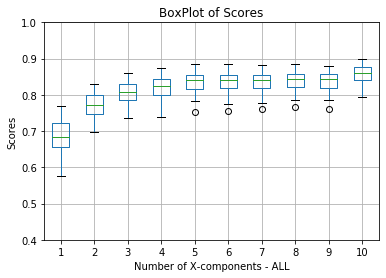

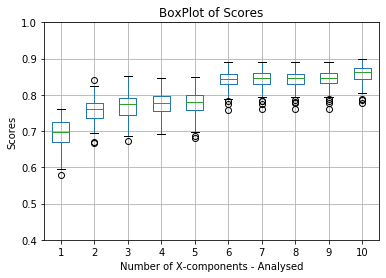

In [30]:
scorem=np.zeros([len(correlation),50])

for i in range(1,len(correlation)):
    scorem[i,:]=[MLR_model2(stat,i) for stat in range(0,50) ]
#colunas=[var for var in 'abcdefghijklmnopqrstuvxwyz']
colunas=[var for var in 'abcdefghij']
Scores2 = pd.DataFrame(data = np.transpose(scorem[1:11,:]), columns = colunas)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
ax1= Scores2.boxplot(column=colunas)  
plt.xlabel('Number of X-components - ALL')
plt.ylabel('Scores')
plt.title('BoxPlot of Scores')
ax.set(ylim=(0.4,1))
null=ax1.set_xticklabels(['1','2','3','4','5','6','7','8','9','10','11'])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
ax= Scores.boxplot(column=colunas)  
plt.xlabel('Number of X-components - Analysed')
plt.ylabel('Scores')
ax.set(ylim=(0.4,1))
plt.title('BoxPlot of Scores')

null=ax.set_xticklabels(['1','2','3','4','5','6','7','8','9','10','11'])


<h1> Notem que</h1>

Na aplicação direta do MLR_model, as primeiras 5 variáveis são:
 
-    OverallQual, GrLivArea, GarageCars, GarageArea, YearBuilt

Observem como são correlacionadas:

OverallQual  vs SalePrice r= 0.8348945771088325
GrLivArea  vs SalePrice r= 0.7582912224284404
GarageCars  vs SalePrice r= 0.7137387076945219
GarageArea  vs SalePrice r= 0.6980373501287132
YearBuilt  vs SalePrice r= 0.6778599156875884
FullBath  vs SalePrice r= 0.6701588965808558


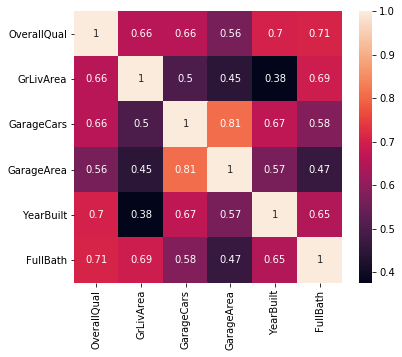

In [33]:
unidunite(['OverallQual', 'GrLivArea','GarageCars','GarageArea','YearBuilt','FullBath'])   

<hr>
Dentre essas 5, entraram na análise mais detalhada apenas o OverallQual e GarageArea,
pois tem r=0.56<0.6.

As variáveis GrLivArea e YearBuilt foram removidas pelo critério de colineariedade, enquanto GarageCars foi removida pois possui menos que 8 valores únicos, mas também seria
removida pois é fortemente correlacionada com GarageArea e OverallQual.
     
Resolvendo o problema da colineariedade, foram necessárias 6 variáveis independentes para alcançar o score da versão enviesada do modelo.

<h1>Observaçoes finais:</h1>

- i) implementar um modelo de regressão linear multipla é relativamente simples;
- ii) percebemos rapidamente a importância em se remover os outliers;
- iii) Neste exemplo, utilizar a PCA para reduzir a dimensionalidade ou encontrar padrões de covariância não teve bons resultados.
    Obtivemos bons resultados, entretanto, fazendo uma análise pontual, em cada grupo de maior covariância, mantendo um membro de cada grupo na análise;
- iv) pudemos reduzir, finalmente, o número de variáveis independentes para 11, obtendo resultados já interessantes a partir da sexta variável independente.